# Pip Installs

### Make Sure to run in Python 3.9.6
### An environment can be created by using conda 

In [6]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.26.0
!pip install pysoundfile
!pip install alive-progress
!pip install scipy
!pip install scikit-learn
!pip install --upgrade pytube
!pip install pydub
!pip install seaborn
!pip install yt_dlp

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [7]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import yt_dlp

# File Creation

### Creating File Paths

In [30]:
unprocessed_train_data_dir = os.path.abspath('') + "/Unprocessed_Training_Wav_Files"
procesed_train_data_dir = os.path.abspath('') + "/Processed_Training_Wav_Files"

unprocessed_test_data_dir = os.path.abspath('') + "/Unprocessed_Testing_Wav_Files"
procesed_test_data_dir = os.path.abspath('') + "/Processed_Testing_Wav_Files"

# YouTube Audio Download

In [62]:
def download_audio(url, starttime, endtime, output):
    # Convert start and end times to seconds
    hours, minutes, seconds = map(int, starttime.split(':'))
    start_time = hours * 3600 + minutes * 60 + seconds
    hours, minutes, seconds = map(int, endtime.split(':'))
    end_time = hours * 3600 + minutes * 60 + seconds
    
     
    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio format
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio after download
            'preferredcodec': 'wav',  # Convert to wav format
        }],
        'noplaylist': True,  # Avoid downloading playlists, download a single video
        'quiet': False,  # Show output in the terminal
        'outtmpl': 'temp_audio.%(ext)s',  # Temporary output for the full audio
    }

    #Use yt-dlp to download the audio
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    
    #Load the downloaded audio using pydub (assume the file was saved as temp_audio.wav)
    audio_file = audio.from_wav('temp_audio.wav')

    #Extract the desired clip (convert time to milliseconds)
    start_time_ms = start_time * 1000  # Convert start time from seconds to milliseconds
    end_time_ms = end_time * 1000      # Convert end time from seconds to milliseconds
    clip = audio_file[start_time_ms:end_time_ms]

    #Export the extracted clip as a new WAV file
    clip.export(output, format="wav")
    print(f"Audio clip saved to {output}")

    #Clean up the temporary file
    #os.remove('temp_audio.wav')

starttime = '0:09:10'
endtime = '0:11:40'
name = 'morganLuttrell40104Clip1'
download_audio(url='https://www.youtube.com/watch?v=wrhHgqweExk',
               starttime=starttime,
               endtime=endtime,
               output=f'{unprocessed_train_data_dir}/{name}.wav')

Audio clip saved to /Users/ryanbirmingham/Downloads/Sunwater Projects/congressional_voice_classification/Unprocessed_Training_Wav_Files/rosaDeLauro40558Clip1.wav


In [63]:
# Run before commit
os.remove('temp_audio.wav')

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [ ]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unprorcessed_Train_Wav_Files and Unprorcessed_Test_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [31]:
for file in os.listdir(unprocessed_train_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_train_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

for file in os.listdir(unprocessed_test_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_test_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

This is a test

In [25]:
f_path = os.path.join(unprocessed_train_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


## Remove the .DS_Store 
### This is a hiddent directory automatically created by Mac OS and causes errors

In [10]:
for folder in procesed_train_data_dir:
    path = os.path.join(folder, ".DS_Store")
    if folder == ".DS_Store":
        os.remove('.DS_Store')     

### Separates the files into 1 second intervals 

##### The files from the unprocessed testing and training wav file folders will go into the 
##### processed testing and training wav file folders

In [32]:
for filename in os.listdir(unprocessed_train_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_train_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{procesed_train_data_dir}/{congress_name}")
                new_audio.export(f"{procesed_train_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{procesed_train_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

for filename in os.listdir(unprocessed_test_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_test_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{procesed_test_data_dir}/{congress_name}")
                new_audio.export(f"{procesed_test_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{procesed_test_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [28]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Training_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [12]:
num_data = 0

for foldr in os.listdir(procesed_train_data_dir):
    if foldr != ".DS_Store":
        num_data += len(os.listdir(f"{procesed_train_data_dir}/{foldr}"))

In [ ]:
def feature_extract (data_dir):
    features = []
    labels = []
    with alive_bar(num_data,force_tty=True, title='Collecting Features', bar = 'scuba') as bar: 
        for foldr in os.listdir(data_dir):
            if foldr != ".DS_Store":
                for file in os.listdir(f"{data_dir}/{foldr}"):
                    arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                    mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                    mfccs = StandardScaler().fit_transform(mfccs)
                    features.append(mfccs.T)
                    labels.append(foldr)
                    bar()
                 
                
    return np.array(features), np.array(labels)           
features, labels = feature_extract(procesed_train_data_dir)

### Count of unique Speakers

In [14]:
unique_labels = list(set(labels))
print(len(unique_labels))

121


### Feature Visualization

In [15]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: mikeThompson, Features Shape: (32, 13)
[-3.1454597   1.5753179  -0.10824029  0.2367027   0.17439431  0.16449606
  0.30459914 -0.12848628 -0.12092715  0.49552506  0.20922267  0.2881198
  0.0547358 ]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.1036396   1.693569    0.5150516   0.31102154  0.1266533   0.15970679
  0.12778513 -0.09254254 -0.08627754  0.06453532  0.01124673  0.24090324
  0.03198699]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.0893676   1.6258458   0.4711262   0.14024734  0.27482828  0.2726772
  0.08423238 -0.44742075 -0.10718002  0.21682575  0.30623186  0.24767725
  0.00427624]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.3528137  -0.19482704  0.5605791   0.75114375  0.3998014   0.27799278
  0.20368046  0.5438508   0.14133175  0.44739565 -0.0530959   0.19697066
  0.07799035]
----------------------------------------
Label: mikeTho

### Training and splitting the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [17]:
print(len(y_test))

7148


In [18]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)

In [19]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(28589, 32, 13)
(28589,)


### Reshape for SVM since it takes 2D arrays

In [20]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [21]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(28589, 416)
(28589,)
['chrisSmith' 'darinLaHood' 'eleanorNorton' ... 'jasonCrow' 'gregSteube'
 'kevinKiley']


### Trying the SVM approach

In [22]:
clm = SVC(kernel="linear", probability=True)

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.4292109681029659


#### Shows the probability for each label for each data set

In [23]:
prob = clm.predict_proba(X_test_SVM)
for i, arr in enumerate(prob):
    prob[i] = np.round(arr * 100,3)

#### Prints all of the probabilities for each test data point

In [85]:
#np.set_printoptions(suppress=True)
#for i in prob:
#    print(i)

#### Prints the True Value, the predicted Value, and the certainty for each test data point

In [86]:
max = 0
for i, val in enumerate(prob):
    max = np.max(val)
    print(f"The True value is {y_test[i]}\n"
          f"The Predicted value is {y_predict[i]} and is {max} certain\n")
    

The True value is michaelMcCaul
The Predicted value is michaelMcCaul and is 8.389 certain

The True value is michaelMcCaul
The Predicted value is sydneyKamlager and is 54.718 certain

The True value is danKildee
The Predicted value is danKildee and is 38.789 certain

The True value is richardMcCormick
The Predicted value is derrickVanOrden and is 44.193 certain

The True value is derrickVanOrden
The Predicted value is davidSchweikert and is 20.35 certain

The True value is gregoryMeeks
The Predicted value is gregoryMeeks and is 54.61 certain

The True value is terriSewell
The Predicted value is terriSewell and is 10.798 certain

The True value is jasonCrow
The Predicted value is jaredMoskowitz and is 35.265 certain

The True value is scottPerry
The Predicted value is scottPerry and is 10.178 certain

The True value is brianMast
The Predicted value is gwenMoore and is 7.352 certain

The True value is addisonWilson
The Predicted value is addisonWilson and is 12.794 certain

The True valu

In [87]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

mikeThompson 
	accuracy = 0.582089552238806
	predict/real = 39/67
michelleFischbach 
	accuracy = 0.3793103448275862
	predict/real = 11/29
johnLarson 
	accuracy = 0.3111111111111111
	predict/real = 14/45
gregSteube 
	accuracy = 0.625
	predict/real = 10/16
dannyDavis 
	accuracy = 0.6486486486486487
	predict/real = 48/74
markGreen 
	accuracy = 0.2459016393442623
	predict/real = 15/61
garretGraves 
	accuracy = 0.734375
	predict/real = 47/64
eleanorNorton 
	accuracy = 0.671875
	predict/real = 86/128
michaelMcCaul 
	accuracy = 0.5398773006134969
	predict/real = 88/163
jerryNadler 
	accuracy = 0.6987951807228916
	predict/real = 58/83
claudiaTenney 
	accuracy = 0.24561403508771928
	predict/real = 14/57
joaquinCastro 
	accuracy = 0.07142857142857142
	predict/real = 1/14
peteStauber 
	accuracy = 0.6274509803921569
	predict/real = 32/51
danKildee 
	accuracy = 0.4418604651162791
	predict/real = 19/43
earlBlumenauer 
	accuracy = 0.5128205128205128
	predict/real = 20/39
chrisPappas 
	accuracy = 0.25

Test Evaluation Accuracy: 0.4319233838786911


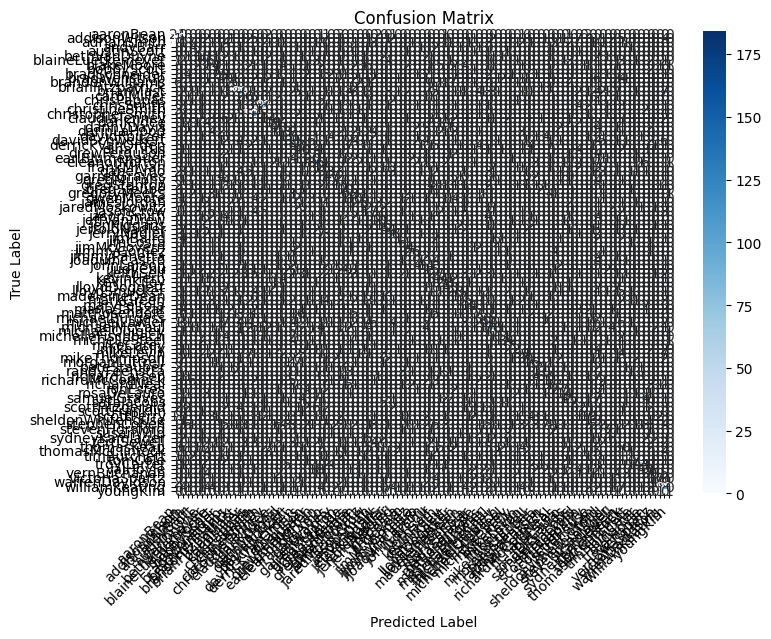

In [88]:
# Decode the labels back to original format
#y_test_decoded = label_encoder.inverse_transform(y_test)
#y_pred_decoded = label_encoder.inverse_transform(y_predict)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Evaluation Accuracy: {accuracy}")

"""
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""

## Try RNN LSTM approach

### Training and testing

In [24]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

Epoch 1/20


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0750 - loss: 4.2312
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3062 - loss: 2.6658
Epoch 3/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4493 - loss: 1.9928
Epoch 4/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5206 - loss: 1.6721
Epoch 5/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5889 - loss: 1.4349
Epoch 6/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6261 - loss: 1.2686
Epoch 7/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6538 - loss: 1.1634
Epoch 8/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6848 - loss: 1.0484
Epoch 9/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7065 - loss: 0.9598
Epoch 10/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7306 - loss: 0.8793
Epoch 11/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7513 - loss: 0.8124
Epoch 12/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accura

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Evaluation Accuracy: 0.7101287073307219


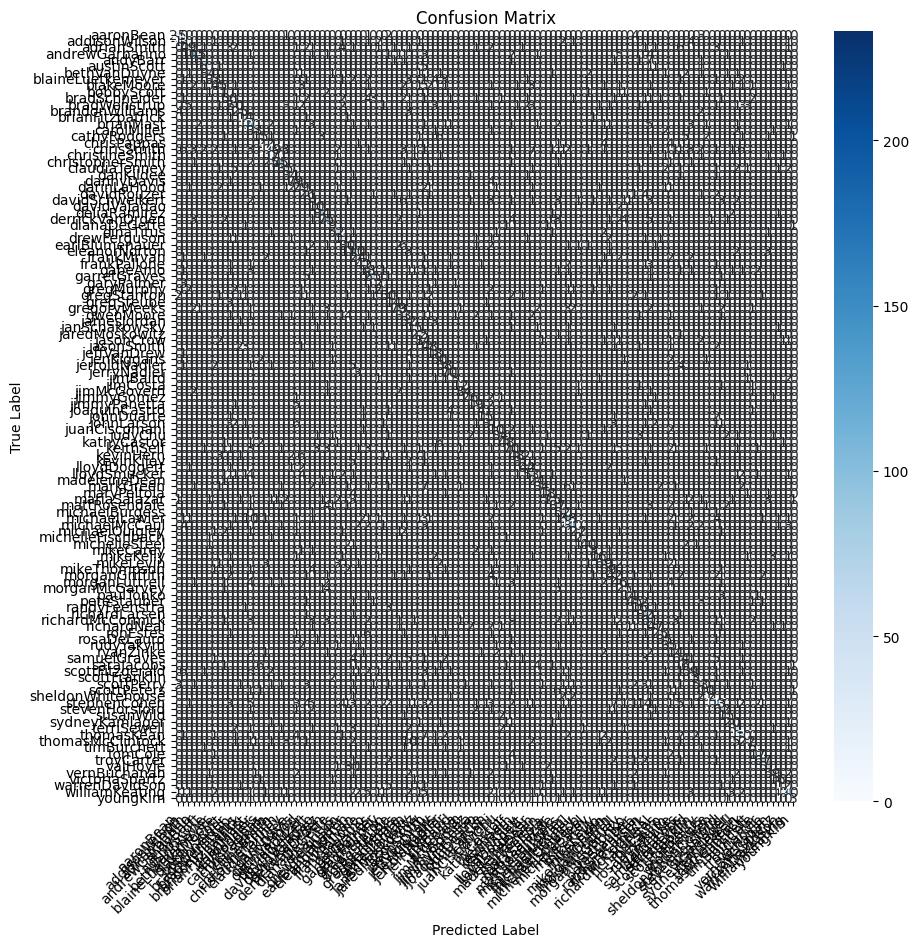

In [ ]:
y_pred_probabilities = model.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")
"""
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""

## Try GRU RNN approach

In [ ]:
num_speakers = len(next(os.walk(procesed_train_data_dir))[1])

np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 121)            │        15,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,033 (277.47 KB)

 Trainable params: 70,777 (276.47 KB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1325 - loss: 4.0872 - val_accuracy: 0.2839 - val_loss: 2.7695
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3508 - loss: 2.5437 - val_accuracy: 0.3696 - val_loss: 2.4147
Epoch 3/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4263 - loss: 2.1733 - val_accuracy: 0.3760 - val_loss: 2.3979
Epoch 4/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4811 - loss: 1.9312 - val_accuracy: 0.5066 - val_loss: 1.8356
Epoch 5/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5154 - loss: 1.7695 - val_accuracy: 0.6042 - val_loss: 1.4546
Epoch 6/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5518 - loss: 1.6276 - val_accuracy: 0.5720 - val_loss: 1.5530
Epoch 7/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5725 - loss: 1.5309 - val_accuracy: 0.6385 - val_loss: 1.3202
Epoch 8/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5890 - loss: 1.4660 - val_accuracy: 0.

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
7148
Test Evaluation Accuracy: 0.7515388919977616


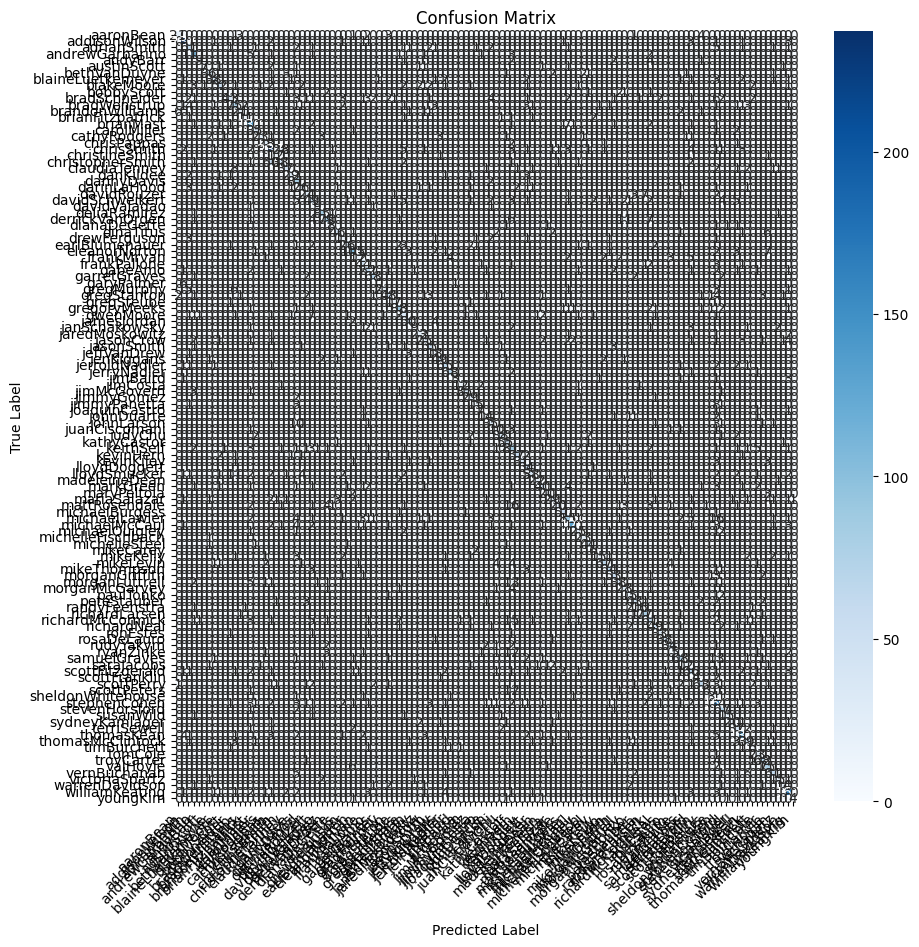

In [ ]:
y_pred_probabilities = gru.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")
"""
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""